<a href="https://colab.research.google.com/github/finardi/WatSpeed_LLM_foundation/blob/main/Module2%3A%20Question_Answering_using_FLAN_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2 - Question Answering using FLAN-T5

This notebook presents an example of how to use Flan-T5 for question answering.

We use the Stanford Question Answering Dataset (SQuAD) as the basis for this example. SQuAD is a popular benchmark dataset for question answering that contains a set of Wikipedia articles and their associated questions and answers. The goal is to develop a model that can read a passage of text and answer a question about it.

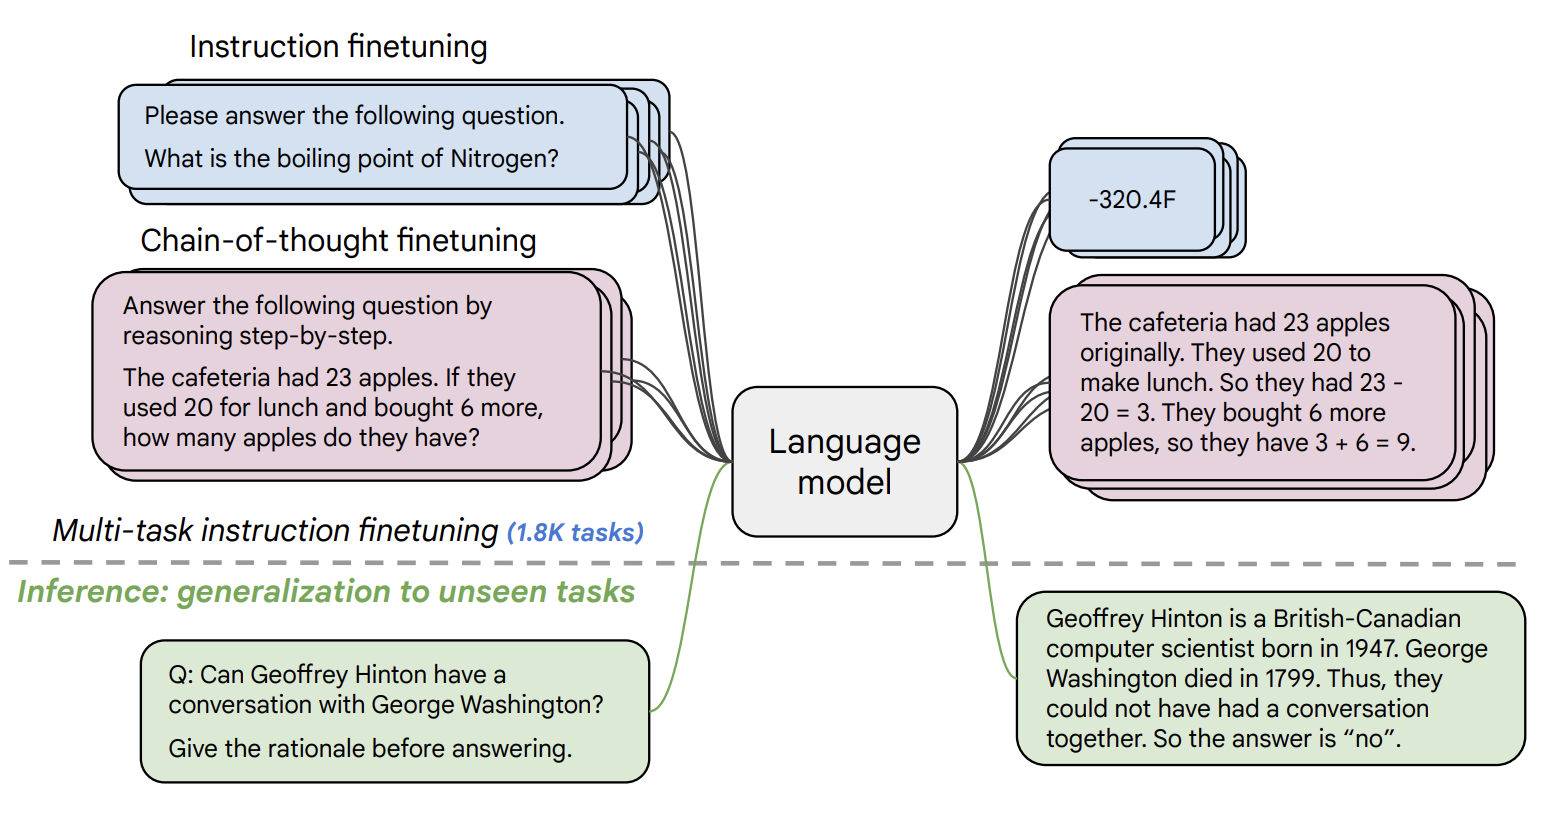


# Installing required packages

In this example, we have to install four libraries:  `transformers`, `datasets`, `sentencepiece` and `accelerate`.

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc. The library is built on top of PyTorch and TensorFlow and provides easy-to-use interfaces to access pre-trained models and fine-tune them on specific tasks. The library also provides tools for training custom models and sharing them with the community.

**`datasets`**:

Datasets is another open-source library developed by Hugging Face that provides a collection of preprocessed datasets for various NLP tasks, such as sentiment analysis, natural language inference, machine translation, and many more. The library provides a unified API to access these datasets, making it easy to load, process, and analyze them.

**`sentencepiece`**:

Sentencepiece is an open-source library developed by Google for subword text processing. It is an unsupervised learning method that constructs a fixed-size vocabulary of subword units for a given language corpus. Sentencepiece enables the generation of a custom tokenization scheme that divides text into smaller subword units, which can better handle rare words and out-of-vocabulary words than traditional word-based tokenization.

**`accelerate`**:

`accelerate` is a library developed by Hugging Face that provides a PyTorch-based training and evaluation pipeline optimized for distributed training across multiple GPUs. It leverages PyTorch's DistributedDataParallel module to allow for easy multi-GPU training, and also provides features such as gradient accumulation, gradient checkpointing, and mixed precision training. `accelerate` can significantly reduce training time for large models and datasets by enabling parallel processing across multiple GPUs.


In [ ]:
!pip install transformers 
!pip install datasets
!pip install sentencepiece
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:0

# Setting the device

In this example, we will use a GPU to speed up the processing of our model. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU. 

For using a GPU in Google Colab: 
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook. 

In [ ]:
!nvidia-smi

Sat May  6 12:55:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Downloading the dataset

In this section, we are downloading the SQuAD dataset using the **`load_dataset()`** function from the **`datasets`** library. SQuAD (Stanford Question Answering Dataset) is a popular benchmark dataset for reading comprehension tasks. It consists of questions and answers based on a set of Wikipedia articles. The task is to answer questions posed by humans based on the given article. The dataset is split into training and validation sets, and each question is associated with a context paragraph and an answer. 

Here, we are downloading a subset of the validation split of the dataset, which contains 500 examples. You can use different sizes for the validation split by changing the value inside the brackets. For example, you can use `[:1000]` to download the first 1000 examples from the validation split. If you want to download the entire validation split (10.6k examples), you can remove `[:500]` from the function call.



In [ ]:
from datasets import load_dataset

val_dataset = load_dataset('squad', split='validation[:500]')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


# Downloading the model

The code below downloads and initializes a T5 model from Hugging Face's Transformers library. T5 is a powerful transformer-based model that can be fine-tuned for a variety of NLP tasks, including summarization, question answering, and text generation.

First, we set the **`BASE_MODEL`** variable to **`"google/flan-t5-xl"`**, which specifies the pre-trained T5 model to download. This model is the extra-large version of the T5 model, which has 3B parameters and achieved state-of-the-art performance on many benchmarks.

Then, we use the **`T5Tokenizer`** class from the Transformers library to download and initialize the tokenizer for the specified model. The tokenizer is responsible for tokenizing the input text and encoding it into a numerical format that can be fed into the model.

Next, we use the **`T5ForConditionalGeneration`** class to download and initialize the pre-trained T5 model specified by the **`BASE_MODEL`** variable. This class provides an interface for generating text based on a given input sequence. The **`torch_dtype=torch.float16`** and **`low_cpu_mem_usage=True`** arguments are optional and configure the model to use half-precision floating-point numbers and minimize CPU memory usage, respectively.

Finally, we move the model to the specified device, which is likely a GPU. This is necessary for the model to perform inference on large amounts of data efficiently.

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

BASE_MODEL = "google/flan-t5-xl"

tokenizer = T5Tokenizer.from_pretrained(BASE_MODEL)
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL, torch_dtype=torch.float16, low_cpu_mem_usage=True)

model = model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Inference

The **`generate()`** function below is responsible for generating text from the Flan-T5 XL model. 

It takes an **`input_text`** parameter, which is the text used as input for generating the response. It then tokenizes the **`input_text`** using the Flan-T5 XL model's tokenizer, which is loaded in the previous code snippet. The tokenizer converts the input text into token IDs that can be used as input for the model.

Next, it generates the response using the **`model.generate()`** method. This method takes the token IDs from the input text as input and returns a tensor of generated token IDs that represent the model's generated response. In this case, the **`do_sample=False`** argument is used to disable sampling and force the model to return the top-scoring output sequence.

The **`max_length`** argument limits the maximum length of the generated output to 128 tokens. If the output exceeds this limit, the model will truncate the response to the maximum length.

Finally, the function decodes the generated token IDs back into human-readable text using the Flan-T5 XL tokenizer's **`decode()`** method, excluding any special tokens (**`skip_special_tokens=True`**). The generated output is then returned.

In [ ]:
def generate(input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    gen_tokens = model.generate(
        input_ids,
        do_sample=False,
        max_length=128)
    output_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)
    return output_text

You can test Flan-T5 with your own texts in the cell below. Try asking a question or requesting reasoning about a mathematical problem.

In [ ]:
text = "Q: Can Geoffrey Hinton have a conversation with George Washington? Give the rationale before answering." # @param
generate(text)

'George Washington died in 1799. Geoffrey Hinton was born in 1924. So the final answer is no.'

# Question Answering

The function **`question_answering`** takes a dictionary **`item`** as input that contains two keys, **`context`** and **`question`**, representing the context and the question, respectively. The function then creates a string **`prompt`** that includes the context and the question, and calls the **`generate`** function to generate the answer for the given question and context using the Flan-T5 XL model. Finally, the function returns the generated answer as a string.

In other words, this function uses the **`generate`** function to perform question answering by providing the context and the question as input and generating an answer using the Flan-T5 XL model.

In [ ]:
def question_answering(item):
  prompt = "Question Answering:\nContext: {0}\nQuestion: {1}\nAnswer:".format(item['context'],item['question'])

  return generate(prompt)

The code above is performing question answering on the validation split of the SQuAD dataset using the **`question_answering()`** function defined earlier to generate answers given a context and a question. 

First, it imports the **`tqdm`** package to show a progress bar during the inference process. 

Then, it initializes two empty lists **`predicted`** and **`references`** to store the predicted answers and the correct answers from the dataset, respectively.

After that, the code starts a for loop to iterate over all the items in the `**val_dataset`** using the **`tqdm`** progress bar. 

In each iteration, the **`question_answering()`** function is called with the current item as input, which includes the context and the question for the model to answer. The function generates an answer given the context and question, and appends it to the **`predicted`** list.

The correct answer(s) for the question are extracted from the item and appended to the **`references`** list.

Finally, the **`predicted`** and **`references`** lists can be used to evaluate the performance of the model on the SQuAD dataset using metrics such as F1 score and exact match.

In [ ]:
from tqdm import tqdm

predicted = []
references = []
for item in tqdm(val_dataset):
  predicted.append(question_answering(item))
  references.append(item['answers'])

100%|██████████| 500/500 [01:33<00:00,  5.36it/s]


# Evaluation

In this section, we evaluate the performance of our model by calculating the exact match score and the F1 score using bag of words. To accomplish this, we have defined some helper functions. 

The **`normalize_text`** function takes a text and normalizes it by converting it to lowercase and removing any non-alphanumeric characters. The **`get_tokens`** function tokenizes the text after normalization.

The **`exact_match`** function takes the predicted answer and the true answer and returns whether they match exactly after normalization. The **`f1_bag_of_words`** function takes the predicted answer and the true answer, tokenizes them, and calculates their F1 score using the bag of words approach. 

The bag of words approach is a technique used to measure the similarity between two sets of texts by counting the frequency of each word in both sets and then calculating their overlap.

In [ ]:
import re
from collections import Counter

def normalize_text(text):
    """
    Helper function to normalize the text
    """
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    return text.strip()

def get_tokens(text):
    """
    Helper function to tokenize text
    """
    text = normalize_text(text)
    return text.split()

def exact_match(pred_answer, true_answer):
    """
    Calculates the exact match score
    """
    return normalize_text(pred_answer) == normalize_text(true_answer)

def f1_bag_of_words(pred_answer, true_answer):
    """
    Calculates the F1 score using bag of words
    """
    pred_tokens = get_tokens(pred_answer)
    true_tokens = get_tokens(true_answer)

    pred_counter = Counter(pred_tokens)
    true_counter = Counter(true_tokens)

    common = pred_counter & true_counter
    num_same = sum(common.values())

    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(true_tokens)
    f1 = (2 * precision * recall) / (precision + recall)

    return f1


In the below code, we are evaluating the performance of our Flan-T5 XL model for question answering by calculating the Exact Match (EM) and F1 score using bag of words. 

The code iterates over each item in the validation dataset and calculates the F1 and EM scores using the **`f1_bag_of_words`** and **`exact_match`** functions defined earlier. The maximum score of F1 and EM is then taken for each item and appended to their respective lists, **`f1s`** and **`ems`**. 

The mean of the **`f1s`** and **`ems`** lists are then calculated using NumPy's **`np.mean`** function and assigned to **`mean_f1`** and **`mean_em`** variables, respectively. Finally, the average EM and F1 scores are printed using formatted string literals.

In [ ]:
import numpy as np

f1s, ems = [], []
for ref, pred in zip(references, predicted):
    f1 = max(f1_bag_of_words(pred, r) for r in ref["text"])
    em = max(exact_match(pred, r) for r in ref["text"])
    f1s.append(f1)
    ems.append(em)

mean_em = np.mean(ems)
mean_f1 = np.mean(f1s)
print(f"Exact match: {mean_em:.3f}\nF1-bow: {mean_f1:.3f}")

Exact match: 0.924
F1-bow: 0.940


# Try with your data

Provide a context-question pair with which you are familiar to test the model's performance.



In [ ]:
context = "This paper proposes a question-answering system that can answer questions whose supporting evidence is spread over multiple (potentially long) documents. The system, called Visconde, uses a three-step pipeline to perform the task: decompose, retrieve, and aggregate. The first step decomposes the question into simpler questions using a few-shot large language model (LLM). Then, a state-of-the-art search engine is used to retrieve candidate passages from a large collection for each decomposed question. In the final step, we use the LLM in a few-shot setting to aggregate the contents of the passages into the final answer. The system is evaluated on three datasets: IIRC, Qasper, and StrategyQA. Results suggest that current retrievers are the main bottleneck and that readers are already performing at the human level as long as relevant passages are provided. The system is also shown to be more effective when the model is induced to give explanations before answering a question." # @param
question = "What is the main bottleneck?" # @param

answer = question_answering({
    "context":context,
    "question":question
})
print(f"Answer: {answer}")

Answer: current retrievers
